In [1]:
# Read data
from PIL import Image
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

batch_size = 32
workers = 3
image_size = 28

trans = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    
train_dataset = datasets.MNIST(root = './datasets/train',train = True, transform = trans, download = True)
test_dataset = datasets.MNIST(root = './datasets/test',train = False, transform = trans, download = True)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

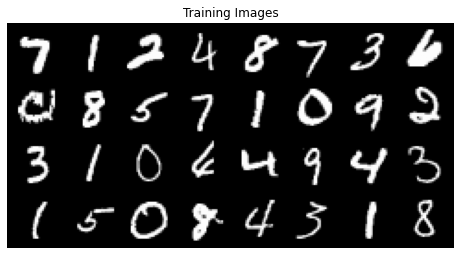

In [2]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].cpu()[:32], padding=2, normalize=True).cpu(),(1,2,0)))

In [3]:
# Build model

import torch.nn as nn

loop = 1

# 1. CNN
class CNN(nn.Module):
    def __init__(self, input_channels, num_class = 10, features_d = 32):
        super(CNN,self).__init__()
        cnl_modules = []
        cnl_modules.append(self._conv(input_channels, features_d,3,1,0))
        for i in range(loop):
            cnl_modules.append(self._conv(features_d * (2**i), features_d * (2**(i+1)),3,1,0))
        ll_modules = []
        ll_modules.append(nn.Linear((5*5)*features_d * (2**loop), features_d))
        ll_modules.append(nn.Linear(features_d,num_class))
        self.cnl = nn.Sequential(*cnl_modules)
        self.ll  = nn.Sequential(*ll_modules)
    
    def _conv(self, in_channel, out_channel, kernel_size, stride, padding=0):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias = False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
            )
    
    def forward(self, x):
        x = self.cnl(x)
        x = x.reshape(x.shape[0],-1)
        x = self.ll(x)
        return x


In [4]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_CNN = CNN(1).to(device)
print(model_CNN)

CNN(
  (cnl): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (ll): Sequential(
    (0): Linear(in_features=1600, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [5]:
from torchsummary import summary
summary(model_CNN,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             288
       BatchNorm2d-2           [-1, 32, 26, 26]              64
              ReLU-3           [-1, 32, 26, 26]               0
         MaxPool2d-4           [-1, 32, 13, 13]               0
            Conv2d-5           [-1, 64, 11, 11]          18,432
       BatchNorm2d-6           [-1, 64, 11, 11]             128
              ReLU-7           [-1, 64, 11, 11]               0
         MaxPool2d-8             [-1, 64, 5, 5]               0
            Linear-9                   [-1, 32]          51,232
           Linear-10                   [-1, 10]             330
Total params: 70,474
Trainable params: 70,474
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.73
Params size (MB): 0.27
Estimated Tot

In [6]:
# Loss and optmizer
# reference: https://github.com/yunjey/pytorch-tutorial

import torch.optim as optim

learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_CNN.parameters(), lr = learning_rate)

In [7]:
# Train the model

num_epochs = 10

batch_num = len(train_dataloader)

for epoch in range(num_epochs):
    for batch_idx, (image,label) in enumerate(train_dataloader):
        image = image.to(device)
        label = label.to(device)
        
        outcome = model_CNN(image)
        loss = criterion(outcome,label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 375 == 0:
            print(f"Epoch: [{epoch+1}/{num_epochs}],  Batch: [{batch_idx+375}/{len(train_dataloader)}],  Loss: {loss:.4f}")
        

Epoch: [1/10],  Batch: [375/1875],  Loss: 2.3052
Epoch: [1/10],  Batch: [750/1875],  Loss: 0.1020
Epoch: [1/10],  Batch: [1125/1875],  Loss: 0.2463
Epoch: [1/10],  Batch: [1500/1875],  Loss: 0.0613
Epoch: [1/10],  Batch: [1875/1875],  Loss: 0.0817
Epoch: [2/10],  Batch: [375/1875],  Loss: 0.2338
Epoch: [2/10],  Batch: [750/1875],  Loss: 0.0962
Epoch: [2/10],  Batch: [1125/1875],  Loss: 0.1720
Epoch: [2/10],  Batch: [1500/1875],  Loss: 0.1071
Epoch: [2/10],  Batch: [1875/1875],  Loss: 0.1606
Epoch: [3/10],  Batch: [375/1875],  Loss: 0.1379
Epoch: [3/10],  Batch: [750/1875],  Loss: 0.1007
Epoch: [3/10],  Batch: [1125/1875],  Loss: 0.2364
Epoch: [3/10],  Batch: [1500/1875],  Loss: 0.0062
Epoch: [3/10],  Batch: [1875/1875],  Loss: 0.0037
Epoch: [4/10],  Batch: [375/1875],  Loss: 0.1186
Epoch: [4/10],  Batch: [750/1875],  Loss: 0.0294
Epoch: [4/10],  Batch: [1125/1875],  Loss: 0.0742
Epoch: [4/10],  Batch: [1500/1875],  Loss: 0.0088
Epoch: [4/10],  Batch: [1875/1875],  Loss: 0.0073
Epoch: [

In [8]:
# Test
model_CNN.eval()

with torch.no_grad():
    yes,total = 0,0
    for image,label in test_dataloader:
        image = image.to(device)
        label = label.to(device)
        outcome = model_CNN(image)
        temp,out = torch.max(outcome.data,1)
        total += label.size(0)
        yes += (out == label).sum().item()
    print(f"True: {yes}, Total {total}, Accuracy: {yes/total}")

True: 9899, Total 10000, Accuracy: 0.9899
